# Importing Modules/Libraries

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torchvision.transforms import functional as F
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim

from torchvision import models


# Function to load imgaes from the folders

In [17]:
def load_images_from_folder(folder, extensions=["*.jpg", "*.jpeg", "*.png", "*.JPG"]):
    images = []
    for ext in extensions:
        for f in glob.iglob(os.path.join(folder, ext)):
            img = cv2.imread(f)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                b, g, r = cv2.split(img)
                img = cv2.merge([r, g, b])
                images.append(img)
    return images

# Function to plot some random images

In [23]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('No Tumor')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])


# Ploting 5 random images from Tumor and No-Tumor dataset

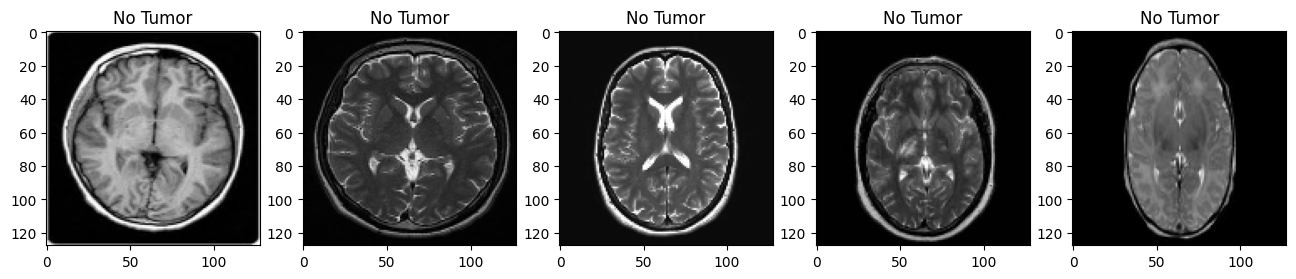

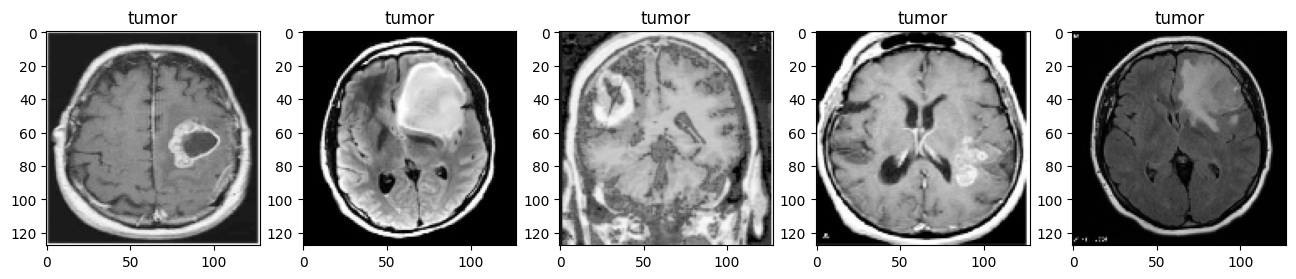

In [25]:
no_tumor = []
tumor = []
tumor = load_images_from_folder("/content/drive/MyDrive/Internship/data/yes/")

# Load images without tumors
no_tumor = load_images_from_folder("/content/drive/MyDrive/Internship/data/no/")
plot_random(np.array(no_tumor), np.array(tumor), num=5)

# Pytorch Dataset Class

In [15]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, index):
        raise NotImplementedError

# MRI Datadet Class inherited from pytorch dataset class


In [20]:
class MRIDataset(Dataset):
    def __init__(self):
        # Define the preprocessor pipeline, no need for ToPILImage since we already have numpy arrays
        self.preprocessor = transforms.Compose([
            transforms.ToTensor(),  # Convert image to tensor directly from numpy array
            transforms.Resize((128, 128)),  # Resize to 128x128 (requires tensor, not PIL)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        ])

        # Load images using the function
        tumor_images = load_images_from_folder("/content/drive/MyDrive/Internship/data/yes/")
        no_tumor_images = load_images_from_folder("/content/drive/MyDrive/Internship/data/no/")


        # Labels
        tumor_label = torch.ones(len(tumor_images), dtype=torch.float32)
        healthy_label = torch.zeros(len(no_tumor_images), dtype=torch.float32)

        # Apply preprocessing and convert to tensor
        tumor = [self.preprocess_and_resize(img) for img in tumor_images]
        healthy = [self.preprocess_and_resize(img) for img in no_tumor_images]

        # Concatenate
        self.images = torch.stack(tumor + healthy)
        self.labels = torch.cat([tumor_label, healthy_label])
        # function to preprocess the data
    def preprocess_and_resize(self, img):
        img_pil = Image.fromarray(img)
        img_tensor = self.preprocessor(img_pil)
        return img_tensor
        # funcction to get length of the data
    def __len__(self):
        return len(self.labels)
        # function that return an image and its label on the provided index
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label


# Creating a Dataset Object and spliting data into Test & Train Loader

In [21]:
dataset = MRIDataset()
X_train, X_test, y_train, y_test = train_test_split(dataset.images, dataset.labels, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = MRIDataset()
train_dataset.images = X_train
train_dataset.labels = y_train

test_dataset = MRIDataset()
test_dataset.images = X_test
test_dataset.labels = y_test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Custom Neural Network architecture For binary classifiaction

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),

            nn.MaxPool2d(kernel_size=2, stride=5)
        )

        # Adjusting the in_features for the first linear layer
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=16*4*4, out_features=120),  # 16*4*4 = 256
            nn.Linear(in_features=120, out_features=84),
            nn.Linear(in_features=84, out_features=2)  # Binary classification, so 2 output features
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_model(x)
        return x

# Training loop to train the Neural Network

In [ ]:
def train_model(model, optimizer, epochs):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_acc = calc_acc(train_loader, model)
        test_acc = calc_acc(test_loader, model)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}, Test Acc: {test_acc:.2f}')

# Accuracy Calcuator Function

In [ ]:
def calc_acc(loader,model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Function to evaluate the Model

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    outputs, true_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)
            _, predicted = torch.max(y_hat, 1)
            outputs.append(predicted.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    outputs = np.concatenate(outputs, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return outputs, true_labels

# Function to print Statiscical Metrics of each Neural Network Model

In [ ]:
def stats(outputs, y_true):
    accuracy = accuracy_score(y_true, outputs)
    precision = precision_score(y_true, outputs)
    recall = recall_score(y_true, outputs)
    cm = confusion_matrix(y_true, outputs)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print("Confusion Matrix:")
    print(cm)

# Functions to import pretarined VGG-Net and Resnet model and prepare them for transfr learning

In [ ]:
def get_vgg16():
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze all layers except the classifier
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # Modify final layer for binary classification
    return model

def get_resnet50():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers except the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, 2)  # Modify final layer for binary classification
    return model

# Initializing Custom Neural Network Model

In [ ]:
cnn_model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Define loss function and optimizer
eta = 0.001
EPOCH = 10
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=eta)
loss_function = nn.CrossEntropyLoss()



# Starting Model Training On CNN


In [ ]:
# Train the model
train_model(cnn_model, optimizer, epochs=EPOCH)

Epoch [1/10], Loss: 0.6497, Train Acc: 63.37, Test Acc: 52.94
Epoch [2/10], Loss: 0.5812, Train Acc: 78.71, Test Acc: 74.51
Epoch [3/10], Loss: 0.5449, Train Acc: 77.72, Test Acc: 82.35
Epoch [4/10], Loss: 0.4539, Train Acc: 82.18, Test Acc: 82.35
Epoch [5/10], Loss: 0.4338, Train Acc: 81.68, Test Acc: 80.39
Epoch [6/10], Loss: 0.4243, Train Acc: 79.70, Test Acc: 80.39
Epoch [7/10], Loss: 0.3944, Train Acc: 86.14, Test Acc: 84.31
Epoch [8/10], Loss: 0.3214, Train Acc: 89.60, Test Acc: 88.24
Epoch [9/10], Loss: 0.2374, Train Acc: 91.09, Test Acc: 84.31
Epoch [10/10], Loss: 0.2074, Train Acc: 94.06, Test Acc: 88.24


# Evaluating Model predicted outputs with true outputs to calculate metrics

In [ ]:
CNN_outputs, CNN_true = evaluate_model(cnn_model, test_loader)

In [ ]:
print("Custom Neural Newtwork Metrics:")
stats(CNN_outputs, CNN_true)


Custom Neural Newtwork Metrics:
Accuracy: 0.8823529411764706
Precision: 0.92
Recall: 0.8518518518518519
Confusion Matrix:
[[22  2]
 [ 4 23]]


# Initializing VGG-Net Model

In [ ]:
vgg_model = get_vgg16().to(device)
optimizer_vgg = optim.Adam(vgg_model.classifier[6].parameters(), lr=0.001)


# Starting Model Training On VGG-Net

In [ ]:
train_model(vgg_model, optimizer_vgg, epochs=10)


Epoch [1/10], Loss: 0.7354, Train Acc: 73.76, Test Acc: 84.31
Epoch [2/10], Loss: 0.4835, Train Acc: 80.69, Test Acc: 80.39
Epoch [3/10], Loss: 0.5205, Train Acc: 83.17, Test Acc: 86.27
Epoch [4/10], Loss: 0.3960, Train Acc: 86.14, Test Acc: 92.16
Epoch [5/10], Loss: 0.4375, Train Acc: 91.58, Test Acc: 90.20
Epoch [6/10], Loss: 0.3688, Train Acc: 89.60, Test Acc: 94.12
Epoch [7/10], Loss: 0.3440, Train Acc: 93.07, Test Acc: 94.12
Epoch [8/10], Loss: 0.3294, Train Acc: 92.57, Test Acc: 92.16
Epoch [9/10], Loss: 0.3094, Train Acc: 94.06, Test Acc: 90.20
Epoch [10/10], Loss: 0.2891, Train Acc: 96.04, Test Acc: 94.12


# Evaluating Model predicted outputs with true outputs to calculate metrics

In [ ]:
vgg_outputs, vgg_true = evaluate_model(vgg_model, test_loader)


In [ ]:
print("VGG-Net Metrics:")
stats(vgg_outputs, vgg_true)

VGG-Net Metrics:
Accuracy: 0.9411764705882353
Precision: 0.9615384615384616
Recall: 0.9259259259259259
Confusion Matrix:
[[23  1]
 [ 2 25]]


# Initializing Resnet Model

In [ ]:
resnet_model = get_resnet50().to(device)
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)


# Starting Model Training On Resnet

In [ ]:
train_model(resnet_model, optimizer_resnet, epochs=10)


Epoch [1/10], Loss: 0.6075, Train Acc: 78.71, Test Acc: 82.35
Epoch [2/10], Loss: 0.3893, Train Acc: 81.68, Test Acc: 80.39
Epoch [3/10], Loss: 0.3252, Train Acc: 89.60, Test Acc: 96.08
Epoch [4/10], Loss: 0.3120, Train Acc: 88.12, Test Acc: 90.20
Epoch [5/10], Loss: 0.2781, Train Acc: 91.58, Test Acc: 94.12
Epoch [6/10], Loss: 0.2535, Train Acc: 92.57, Test Acc: 96.08
Epoch [7/10], Loss: 0.2032, Train Acc: 92.08, Test Acc: 94.12
Epoch [8/10], Loss: 0.1984, Train Acc: 95.54, Test Acc: 96.08
Epoch [9/10], Loss: 0.2201, Train Acc: 97.03, Test Acc: 96.08
Epoch [10/10], Loss: 0.2220, Train Acc: 98.02, Test Acc: 98.04


# Evaluating Model predicted outputs with true outputs to calculate metrics

In [ ]:
resnet_outputs, resnet_true = evaluate_model(resnet_model, test_loader)


In [ ]:
print("ResNet Metrics:")

stats(resnet_outputs, resnet_true)

ResNet Metrics:
Accuracy: 0.9803921568627451
Precision: 0.9642857142857143
Recall: 1.0
Confusion Matrix:
[[23  1]
 [ 0 27]]


# Comparing Metrics of all the Neural Networks

In [ ]:
print("Custom Neural Newtwork Metrics:")
stats(CNN_outputs, CNN_true)

print("\nVGG-Net Metrics:")
stats(vgg_outputs, vgg_true)

print("\nResNet Metrics:")
stats(resnet_outputs, resnet_true)

Custom Neural Newtwork Metrics:
Accuracy: 0.8823529411764706
Precision: 0.92
Recall: 0.8518518518518519
Confusion Matrix:
[[22  2]
 [ 4 23]]

VGG-Net Metrics:
Accuracy: 0.9411764705882353
Precision: 0.9615384615384616
Recall: 0.9259259259259259
Confusion Matrix:
[[23  1]
 [ 2 25]]

ResNet Metrics:
Accuracy: 0.9803921568627451
Precision: 0.9642857142857143
Recall: 1.0
Confusion Matrix:
[[23  1]
 [ 0 27]]


# Saving the best model on the google drive

In [ ]:
best_model = resnet_model
torch.save(best_model, '/content/drive/MyDrive/Internship/best_brain_tumor_model.pth')